# 09 — Normalization and Preprocessing

Purpose: compare standardization vs min-max scaling, fit preprocessing on train only, and see how scaling changes gradient descent dynamics (speed, stability, and effective learning rate).

## Learning goals
- Implement standardization and min-max scaling.
- Fit transforms on train only and apply to val/test.
- Visualize how feature scales affect loss curves under gradient descent.
- Build intuition: scaling is not “cosmetic”; it changes optimization geometry.

## Prerequisites
- Notebook 08 (no leakage).
- Basic gradient descent loop.
- Comfort with plots.

## Key ideas
- If one feature is 1000x larger, gradients can be dominated by that feature.
- Standardization: zero mean, unit variance.
- Min-max: map to [0,1] per feature.
- Preprocessing parameters must be fit on train only.

## Minimal theory
- Gradient descent steps depend on scale: `dW = x^T dz`.
- Poor scaling can force tiny learning rates to avoid divergence.
- Good scaling makes learning rates more transferable across problems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def bce_from_logits(z, y):
    t = np.maximum(z, 0) - z*y + np.log1p(np.exp(-np.abs(z)))
    return float(np.mean(t))

def standardize_fit(x):
    mu = x.mean(axis=0, keepdims=True)
    sigma = x.std(axis=0, keepdims=True) + 1e-12
    return mu, sigma

def standardize_apply(x, mu, sigma):
    return (x - mu) / sigma

def minmax_fit(x):
    mn = x.min(axis=0, keepdims=True)
    mx = x.max(axis=0, keepdims=True)
    return mn, mx

def minmax_apply(x, mn, mx):
    return (x - mn) / (mx - mn + 1e-12)

def train_val_split(x, y, val_ratio=0.25, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    N = x.shape[0]
    idx = rng.permutation(N)
    n_val = int(N*val_ratio)
    va = idx[:n_val]
    tr = idx[n_val:]
    return x[tr], y[tr], x[va], y[va]

def train_logreg_curve(x_tr, y_tr, x_va, y_va, lr=0.5, steps=500):
    N, D = x_tr.shape
    W = rng.normal(0, 0.1, size=(D,1))
    b = np.zeros((1,1))
    trL, vaL = [], []
    for _ in range(steps):
        z = x_tr @ W + b
        a = sigmoid(z)
        dz = (a - y_tr)/N
        dW = x_tr.T @ dz
        db = np.sum(dz, axis=0, keepdims=True)
        W -= lr*dW
        b -= lr*db
        trL.append(bce_from_logits(x_tr @ W + b, y_tr))
        vaL.append(bce_from_logits(x_va @ W + b, y_va))
    return np.array(trL), np.array(vaL)

# Create a dataset with wildly different feature scales
N = 700
x1 = rng.normal(0, 1.0, size=(N,1))
x2 = rng.normal(0, 1.0, size=(N,1))
x = np.hstack([x1*1000.0, x2])  # x1 dominates scale
W_true = np.array([[0.002], [-1.0]])
b_true = np.array([[0.0]])
logits = x @ W_true + b_true + 0.4*rng.normal(size=(N,1))
y = (logits > 0).astype(float)

x_tr, y_tr, x_va, y_va = train_val_split(x, y, val_ratio=0.25, rng=rng)
print('x_tr mean/std:', x_tr.mean(axis=0), x_tr.std(axis=0))
print('Shapes:', x_tr.shape, y_tr.shape, x_va.shape, y_va.shape)

x_tr mean/std: [-1.32899886e+01 -4.33735123e-03] [995.60688742   1.02670738]
Shapes: (525, 2) (525, 1) (175, 2) (175, 1)


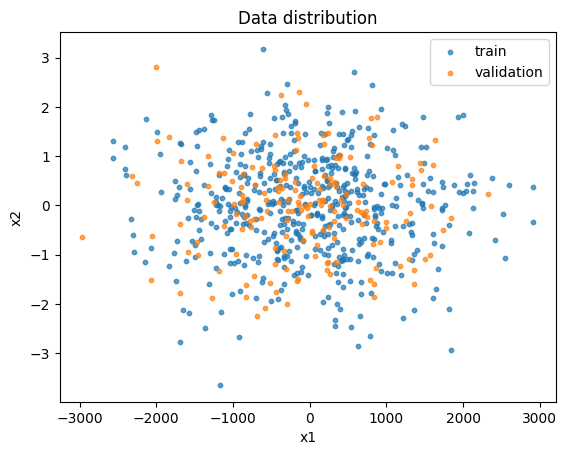

In [3]:
plt.figure()
plt.scatter(x_tr[:,0], x_tr[:,1], s=10, label='train', alpha=0.7)
plt.scatter(x_va[:,0], x_va[:,1], s=10, label='validation', alpha=0.7)
plt.title('Data distribution')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


## Step-by-step experiments
1. Train logistic regression with raw features using a conservative `lr`.
2. Standardize features (fit on train), retrain with a larger `lr`.
3. Min-max scale (fit on train), retrain and compare curves.
4. Visualize feature distributions before/after scaling.

In [4]:
# 1) Raw features: need small lr to avoid divergence
tr_raw, va_raw = train_logreg_curve(x_tr, y_tr, x_va, y_va, lr=1e-5, steps=700)

# 2) Standardization (train-only)
mu, sig = standardize_fit(x_tr)
x_tr_std = standardize_apply(x_tr, mu, sig)
x_va_std = standardize_apply(x_va, mu, sig)
tr_std, va_std = train_logreg_curve(x_tr_std, y_tr, x_va_std, y_va, lr=0.4, steps=700)

# 3) Min-max scaling (train-only)
mn, mx = minmax_fit(x_tr)
x_tr_mm = minmax_apply(x_tr, mn, mx)
x_va_mm = minmax_apply(x_va, mn, mx)
tr_mm, va_mm = train_logreg_curve(x_tr_mm, y_tr, x_va_mm, y_va, lr=0.8, steps=700)

print('Final val losses: raw/std/minmax =', va_raw[-1], va_std[-1], va_mm[-1])

Final val losses: raw/std/minmax = 0.3766197210714704 0.16016177797662356 0.27538673534582786


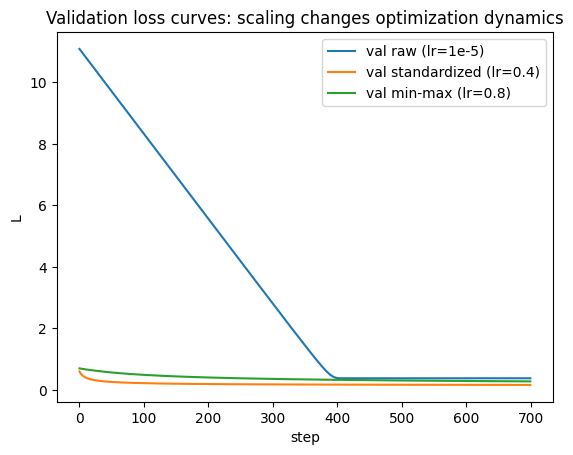

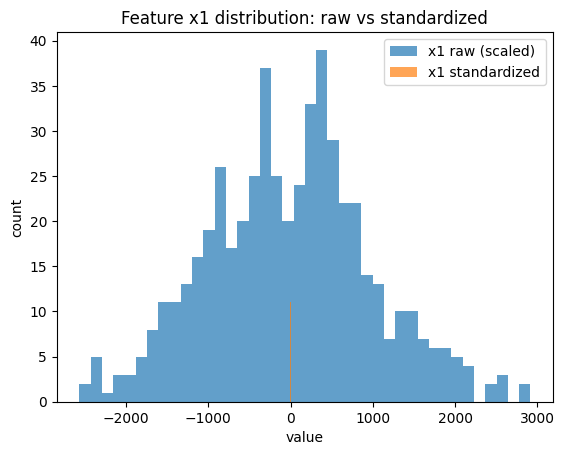

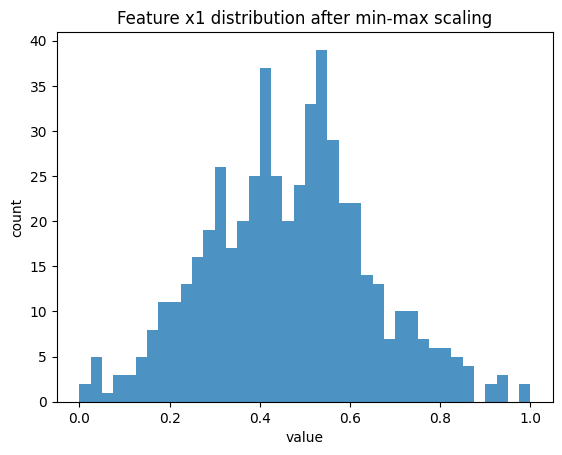

In [5]:
# Plot 1: loss curves
plt.figure()
plt.plot(va_raw, label='val raw (lr=1e-5)')
plt.plot(va_std, label='val standardized (lr=0.4)')
plt.plot(va_mm, label='val min-max (lr=0.8)')
plt.title('Validation loss curves: scaling changes optimization dynamics')
plt.xlabel('step')
plt.ylabel('L')
plt.legend()
plt.show()

# Plot 2: feature distributions before vs after
plt.figure()
plt.hist(x_tr[:,0], bins=40, alpha=0.7, label='x1 raw (scaled)')
plt.hist(x_tr_std[:,0], bins=40, alpha=0.7, label='x1 standardized')
plt.title('Feature x1 distribution: raw vs standardized')
plt.xlabel('value')
plt.ylabel('count')
plt.legend()
plt.show()

plt.figure()
plt.hist(x_tr_mm[:,0], bins=40, alpha=0.8)
plt.title('Feature x1 distribution after min-max scaling')
plt.xlabel('value')
plt.ylabel('count')
plt.show()

## Reflection questions
1. Why did the raw-feature model require a tiny learning rate?
2. How does scaling change the effective step size per dimension?
3. When might min-max be preferable to standardization (and vice versa)?
4. What is a common production bug related to preprocessing?
5. How would you store preprocessing parameters for inference?

## Optional extensions
1. Add an extreme outlier and compare min-max vs standardization sensitivity.
2. Implement robust scaling using median/IQR (still without external libs).
3. Repeat the experiment for a regression task using MSE.

## Summary
- Feature scale changes gradient descent behavior.
- Standardization often stabilizes and accelerates training.
- Min-max scaling can be useful but is outlier-sensitive.
- Fit preprocessing on train only.
- Next: full training with backprop and gradient checking.